# Необходимые модули

In [93]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

from scipy.stats import jarque_bera
from scipy.stats import shapiro

# Вспомогательные функции

In [2]:
def print_least_nan_value_index(data):
    for column in data.columns:
        print(data[data[column].isnull()].index.min(), column)
        
def print_least_missing_value_index(data):
    for column in data.columns:
        print(data[data[column] == -200].index.min(), column)
        
def print_count_nan_value_index(data):
    for column in data.columns:
        print(data[data[column].isnull()].index.size, column)
        
def print_count_missing_value_index(data):
    for column in data.columns:
        print(data[data[column] == -200].index.size, column)


# EDA

Загрузим данные и посмотрим на первую пятерку объектов:

In [3]:
air_quality_data_frame = pd.read_csv('AirQualityUCI/AirQualityUCI.csv', delimiter=';', header=0)

In [4]:
air_quality_data_frame.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


Первые два признака явно можно свести в один (Timestamp), в значениях признаков CO(GT), C6H6(GT), T, RH, AH целая часть отделена от дробной запятой, а не точкой, что, скорее всего, сказывается на типе, в котором эти признаки представлены в выборке. Также последние два признака, похоже, могут вообще никакой информации не содержать.

Взглянем на меры центральной тенденции, изменчивости и т.д.:

In [5]:
air_quality_data_frame.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Unnamed: 15,Unnamed: 16
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,0.0,0.0
mean,1048.990061,-159.090093,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,NaN,NaN
std,329.832710,139.789093,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,NaN,NaN
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,NaN,NaN
25%,921.000000,-200.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,NaN,NaN
50%,1053.000000,-200.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,NaN,NaN
75%,1221.000000,-200.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,NaN,NaN
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,NaN,NaN


Итак, примечательно, что порядок максимальных значений для признака NO2(GT) отличается от прочих на единицу, необходимо будет нормализовать значения признаков. Кроме того, последние два признака целиком состоят из NaN-ов. Собственно, их можно удалять из выборки. Также стоит отметить, что в сформированной таблице отсутствуют статистики по ряду признаков (например T, RH, AH). Это говорит о том, что значения данных признаков загружены не в числовом формате, необходимо будет их в него преобразовать.

Выведем еще немного информации по датасету:

In [6]:
air_quality_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
Date             9357 non-null object
Time             9357 non-null object
CO(GT)           9357 non-null object
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null object
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null object
RH               9357 non-null object
AH               9357 non-null object
Unnamed: 15      0 non-null float64
Unnamed: 16      0 non-null float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


Отметим, что вышеупомянутые признаки (CO(GT), C6H6(GT), T, RH, AH) имеют тип object, хотя по идее должны были быть типа float64. 

Удалим из датасета два последний признака, поскольку они не представляют никакой ценности:

In [7]:
air_quality_data_frame_remove_nan_v_1 = air_quality_data_frame.dropna(axis=1, how='all')

В предыдущей ячейке показано, что объектов в выборке 9471, однако каждый (теперь уже без исключений) признак в выборке имеет только 9357 непустых значений. Вообще говоря, эти 114 пропусков для каждого признака могут быть расположены в разных объектах. Необходимо понять, как они распределены.

Выведем для начала для каждого признака ниаменьший иднекс объекта, на котором значение данного признака пропущено:

In [8]:
print_least_nan_value_index(air_quality_data_frame_remove_nan_v_1)

9357 Date
9357 Time
9357 CO(GT)
9357 PT08.S1(CO)
9357 NMHC(GT)
9357 C6H6(GT)
9357 PT08.S2(NMHC)
9357 NOx(GT)
9357 PT08.S3(NOx)
9357 NO2(GT)
9357 PT08.S4(NO2)
9357 PT08.S5(O3)
9357 T
9357 RH
9357 AH


In [9]:
print_count_nan_value_index(air_quality_data_frame_remove_nan_v_1)

114 Date
114 Time
114 CO(GT)
114 PT08.S1(CO)
114 NMHC(GT)
114 C6H6(GT)
114 PT08.S2(NMHC)
114 NOx(GT)
114 PT08.S3(NOx)
114 NO2(GT)
114 PT08.S4(NO2)
114 PT08.S5(O3)
114 T
114 RH
114 AH


Получается, что для всех признаков в датасете пропуски начинаются с 9358-го объекта, следовательно предыдущие объекты пропусков не имеют. 

Удаляем пустые строки:

In [10]:
air_quality_data_frame_remove_nan_v_2 = air_quality_data_frame_remove_nan_v_1.dropna(axis='index', how='any')

Теперь нужно поправить признаки с запятой в качестве разделителя:

In [11]:
air_quality_data_frame_remove_nan_v_2_CO_GT = air_quality_data_frame_remove_nan_v_2.loc[:, 'CO(GT)'].apply(lambda x: float(str(x).replace(',', '.')))
air_quality_data_frame_remove_nan_v_2_C6H6_GT = air_quality_data_frame_remove_nan_v_2.loc[:, 'C6H6(GT)'].apply(lambda x: float(str(x).replace(',', '.')))
air_quality_data_frame_remove_nan_v_2_T = air_quality_data_frame_remove_nan_v_2.loc[:, 'T'].apply(lambda x: float(str(x).replace(',', '.')))
air_quality_data_frame_remove_nan_v_2_RH = air_quality_data_frame_remove_nan_v_2.loc[:, 'RH'].apply(lambda x: float(str(x).replace(',', '.')))
air_quality_data_frame_remove_nan_v_2_AH = air_quality_data_frame_remove_nan_v_2.loc[:, 'AH'].apply(lambda x: float(str(x).replace(',', '.')))

Сформируем новый датасет, удалив из старого вышеупомянутые признаки и совместив остаток с их преобразованиями:

In [12]:
air_quality_data_frame_remove_nan_v_2 = pd.concat([
    air_quality_data_frame_remove_nan_v_2.drop(['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'], axis='columns'),
    air_quality_data_frame_remove_nan_v_2_CO_GT,
    air_quality_data_frame_remove_nan_v_2_C6H6_GT,
    air_quality_data_frame_remove_nan_v_2_T,
    air_quality_data_frame_remove_nan_v_2_RH,
    air_quality_data_frame_remove_nan_v_2_AH
], axis='columns')

In [13]:
air_quality_data_frame_remove_nan_v_2.head()

,Date,Time,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),CO(GT),C6H6(GT),T,RH,AH
0,10/03/2004,18.00.00,1360.0,150.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,2.6,11.9,13.6,48.9,0.7578
1,10/03/2004,19.00.00,1292.0,112.0,955.0,103.0,1174.0,92.0,1559.0,972.0,2.0,9.4,13.3,47.7,0.7255
2,10/03/2004,20.00.00,1402.0,88.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,2.2,9.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,1376.0,80.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,2.2,9.2,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1272.0,51.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,1.6,6.5,11.2,59.6,0.7888


In [14]:
air_quality_data_frame_remove_nan_v_2.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),CO(GT),C6H6(GT),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,1048.990061,-159.090093,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,-34.207524,1.865683,9.778305,39.485380,-6.837604
std,329.832710,139.789093,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,77.657170,41.380206,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,921.000000,-200.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,0.600000,4.000000,10.900000,34.100000,0.692300
50%,1053.000000,-200.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,1.500000,7.900000,17.200000,48.600000,0.976800
75%,1221.000000,-200.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,2.600000,13.600000,24.100000,61.900000,1.296200
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,11.900000,63.700000,44.600000,88.700000,2.231000


In [15]:
air_quality_data_frame_remove_nan_v_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null object
Time             9357 non-null object
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
CO(GT)           9357 non-null float64
C6H6(GT)         9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


Как видно из двух верхних ячеек теперь признаки CO(GT), C6H6(GT), T, RH, AH имеют числовой тип.

Теперь совместим первые два признака с один и сделаем его индексом:

In [16]:
air_quality_data_frame_remove_nan_v_2_Time = air_quality_data_frame_remove_nan_v_2.loc[:, 'Time'].apply(lambda x: str(x).replace('.', ':'))

In [17]:
air_quality_data_frame_remove_nan_v_2_Timestamp = pd.concat(
    [
        air_quality_data_frame_remove_nan_v_2['Date'],
        air_quality_data_frame_remove_nan_v_2_Time
    ], axis='columns').apply(lambda x: pd.to_datetime(x[0] + ' ' + x[1]), axis='columns')

In [18]:
air_quality_data_frame_remove_nan_v_3 = pd.concat([
    air_quality_data_frame_remove_nan_v_2_Timestamp.rename('Timestamp', inplace=True),
    air_quality_data_frame_remove_nan_v_2.drop(['Date', 'Time'], axis='columns')
], axis='columns')

In [19]:
air_quality_data_frame_remove_nan_v_3.index = air_quality_data_frame_remove_nan_v_3.Timestamp

In [20]:
air_quality_data_frame_remove_nan_v_3.drop('Timestamp', inplace=True, axis='columns')

In [21]:
air_quality_data_frame_remove_nan_v_3.head()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),CO(GT),C6H6(GT),T,RH,AH
Timestamp,,,,,,,,,,,,,
2004-10-03 18:00:00,1360.0,150.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,2.6,11.9,13.6,48.9,0.7578
2004-10-03 19:00:00,1292.0,112.0,955.0,103.0,1174.0,92.0,1559.0,972.0,2.0,9.4,13.3,47.7,0.7255
2004-10-03 20:00:00,1402.0,88.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,2.2,9.0,11.9,54.0,0.7502
2004-10-03 21:00:00,1376.0,80.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,2.2,9.2,11.0,60.0,0.7867
2004-10-03 22:00:00,1272.0,51.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,1.6,6.5,11.2,59.6,0.7888


In [22]:
air_quality_data_frame_remove_nan_v_3.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),CO(GT),C6H6(GT),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,1048.990061,-159.090093,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,-34.207524,1.865683,9.778305,39.485380,-6.837604
std,329.832710,139.789093,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,77.657170,41.380206,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,921.000000,-200.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,0.600000,4.000000,10.900000,34.100000,0.692300
50%,1053.000000,-200.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,1.500000,7.900000,17.200000,48.600000,0.976800
75%,1221.000000,-200.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,2.600000,13.600000,24.100000,61.900000,1.296200
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,11.900000,63.700000,44.600000,88.700000,2.231000


In [23]:
air_quality_data_frame_remove_nan_v_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-10-03 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
CO(GT)           9357 non-null float64
C6H6(GT)         9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: float64(13)
memory usage: 1023.4 KB


По сравнению с первоначальным датасетом текущий его вариант использует примерно на пару сотен КБ меньше. Так же теперь все признаки имеют вполне конкретный тип.

Из описания датасета можно вынести, что отсутствующие значения так же помечены как -200. Взглянем, как много таких значений и где они расположены:

In [24]:
print_least_missing_value_index(air_quality_data_frame_remove_nan_v_3)

2004-01-04 14:00:00 PT08.S1(CO)
2004-01-05 01:00:00 NMHC(GT)
2004-01-04 14:00:00 PT08.S2(NMHC)
2004-01-04 03:00:00 NOx(GT)
2004-01-04 14:00:00 PT08.S3(NOx)
2004-01-04 03:00:00 NO2(GT)
2004-01-04 14:00:00 PT08.S4(NO2)
2004-01-04 14:00:00 PT08.S5(O3)
2004-01-05 04:00:00 CO(GT)
2004-01-04 14:00:00 C6H6(GT)
2004-01-04 14:00:00 T
2004-01-04 14:00:00 RH
2004-01-04 14:00:00 AH


In [25]:
print_count_missing_value_index(air_quality_data_frame_remove_nan_v_3)

366 PT08.S1(CO)
8443 NMHC(GT)
366 PT08.S2(NMHC)
1639 NOx(GT)
366 PT08.S3(NOx)
1642 NO2(GT)
366 PT08.S4(NO2)
366 PT08.S5(O3)
1683 CO(GT)
366 C6H6(GT)
366 T
366 RH
366 AH


Сформируем другой датасет, заменив все значения -200 Nan-ами:

In [26]:
air_quality_data_frame_remove_nan_v_3 = air_quality_data_frame_remove_nan_v_3.replace(-200, np.NaN)
air_quality_data_frame_remove_nan_v_3 = air_quality_data_frame_remove_nan_v_3.replace(-200.0, np.NaN)

In [27]:
air_quality_data_frame_remove_nan_v_3.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),CO(GT),C6H6(GT),T,RH,AH
count,8991.000000,914.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,7674.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,1099.833166,218.811816,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,2.152750,10.083105,18.317829,49.234201,1.025530
std,217.080037,204.459921,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,1.453252,7.449820,8.832116,17.316892,0.403813
min,647.000000,7.000000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,0.100000,0.100000,-1.900000,9.200000,0.184700
25%,937.000000,67.000000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,1.100000,4.400000,11.800000,35.800000,0.736800
50%,1063.000000,150.000000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,1.800000,8.200000,17.800000,49.600000,0.995400
75%,1231.000000,297.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,2.900000,14.000000,24.400000,62.500000,1.313700
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,11.900000,63.700000,44.600000,88.700000,2.231000


In [28]:
air_quality_data_frame_remove_nan_v_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-10-03 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
PT08.S1(CO)      8991 non-null float64
NMHC(GT)         914 non-null float64
PT08.S2(NMHC)    8991 non-null float64
NOx(GT)          7718 non-null float64
PT08.S3(NOx)     8991 non-null float64
NO2(GT)          7715 non-null float64
PT08.S4(NO2)     8991 non-null float64
PT08.S5(O3)      8991 non-null float64
CO(GT)           7674 non-null float64
C6H6(GT)         8991 non-null float64
T                8991 non-null float64
RH               8991 non-null float64
AH               8991 non-null float64
dtypes: float64(13)
memory usage: 1023.4 KB


Как видно из таблицы, минимальные значения поменялись и количества значений для признаков теперь тоже разные.

Так же стоит отметить, что второй признак на $ \frac{9357 - 914}{9357} \cdot 100 \approx 90 \% $ состоит из NaN-ов. Пожалуй его стоит также удалить:

In [29]:
air_quality_data_frame_remove_nan_v_3.drop(['NMHC(GT)'], axis=1, inplace=True)

Воспользуемся стандартным классом из scikit-learn для заполнения этих пропусков.
Поскольку на текущий момент нет каких-то достоверных сведений о том, какой способ заполнения будет лучше, мы используем каждый из них (всего в стандартным классом из scikit-learn их 3) и затем визуально сравним:

In [30]:
imputer_def = Imputer()
imputer_median = Imputer(strategy='median')
imputer_most_frequent = Imputer(strategy='most_frequent')

In [31]:
air_quality_data_frame_remove_nan_v_3_def_imputed = pd.DataFrame(
    data=imputer_def.fit_transform(air_quality_data_frame_remove_nan_v_3.values),
    index=air_quality_data_frame_remove_nan_v_3.index,
    columns=air_quality_data_frame_remove_nan_v_3.columns
)
air_quality_data_frame_remove_nan_v_3_median_imputed = pd.DataFrame(
    data=imputer_median.fit_transform(air_quality_data_frame_remove_nan_v_3.values),
    index=air_quality_data_frame_remove_nan_v_3.index,
    columns=air_quality_data_frame_remove_nan_v_3.columns
)
air_quality_data_frame_remove_nan_v_3_most_frequent_imputed = pd.DataFrame(
    data=imputer_most_frequent.fit_transform(air_quality_data_frame_remove_nan_v_3.values),
    index=air_quality_data_frame_remove_nan_v_3.index,
    columns=air_quality_data_frame_remove_nan_v_3.columns
)

Так, у нас есть три набора данных, в которых по-разному заполнены пропуски.

Перед тем, как визуально оценивать качество заполнения, отделим в каждом наборе целевую переменную от предикторов:

In [32]:
Y_def_imputed = air_quality_data_frame_remove_nan_v_3_def_imputed['C6H6(GT)']
X_def_imputed = air_quality_data_frame_remove_nan_v_3_def_imputed.drop('C6H6(GT)', axis='columns')

Y_median_imputed = air_quality_data_frame_remove_nan_v_3_median_imputed['C6H6(GT)']
X_median_imputed = air_quality_data_frame_remove_nan_v_3_median_imputed.drop('C6H6(GT)', axis='columns')

Y_most_frequent_imputed = air_quality_data_frame_remove_nan_v_3_most_frequent_imputed['C6H6(GT)']
X_most_frequent_imputed = air_quality_data_frame_remove_nan_v_3_most_frequent_imputed.drop('C6H6(GT)', axis='columns')

Глянем теперь на "усатые ящики":

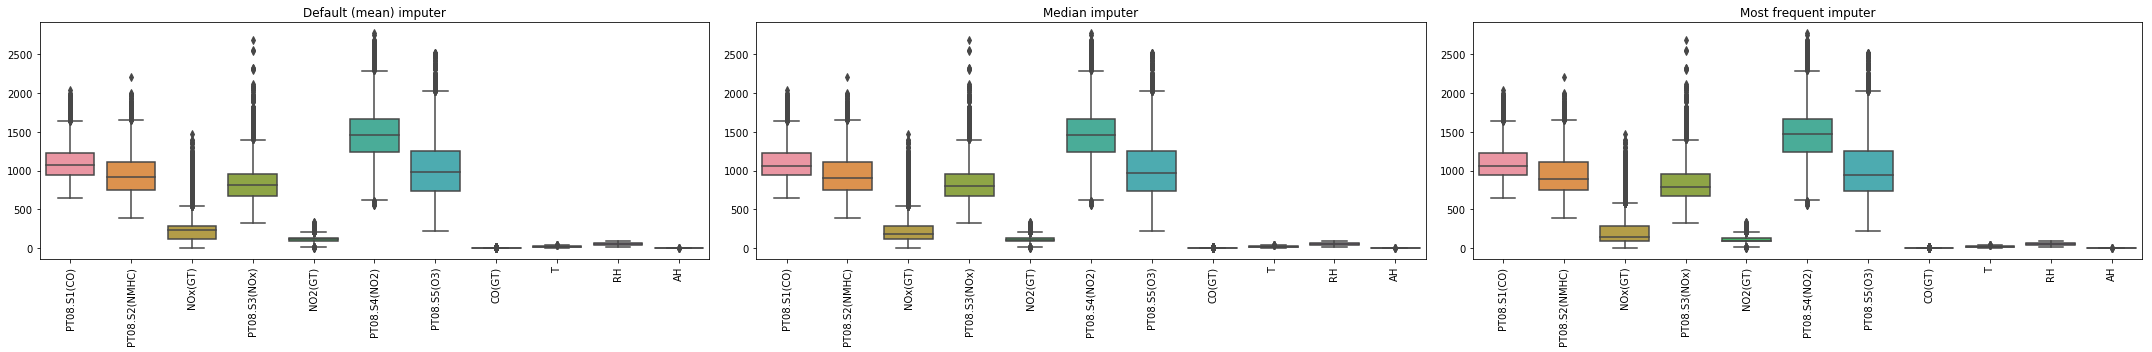

In [33]:
f, axes = plt.subplots(1, 3, figsize=(30, 5))
sns.boxplot(data=X_def_imputed, ax=axes[0])
sns.boxplot(data=X_median_imputed, ax=axes[1])
sns.boxplot(data=X_most_frequent_imputed, ax=axes[2])
axes[0].set_title("Default (mean) imputer")
axes[1].set_title("Median imputer")
axes[2].set_title("Most frequent imputer")
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Сильно разнятся медианы, произвольно гуляет интерквантильный размах, присутствие большого числа потенциальных выбросов - все это говорит о том, что распределения признаков далеки от стандартных.

Тем не менее, по этим графикам нельзя сказать чего-то конкретного о том, какой способ заполнения оказался лучше.

Взглянем на распределения:

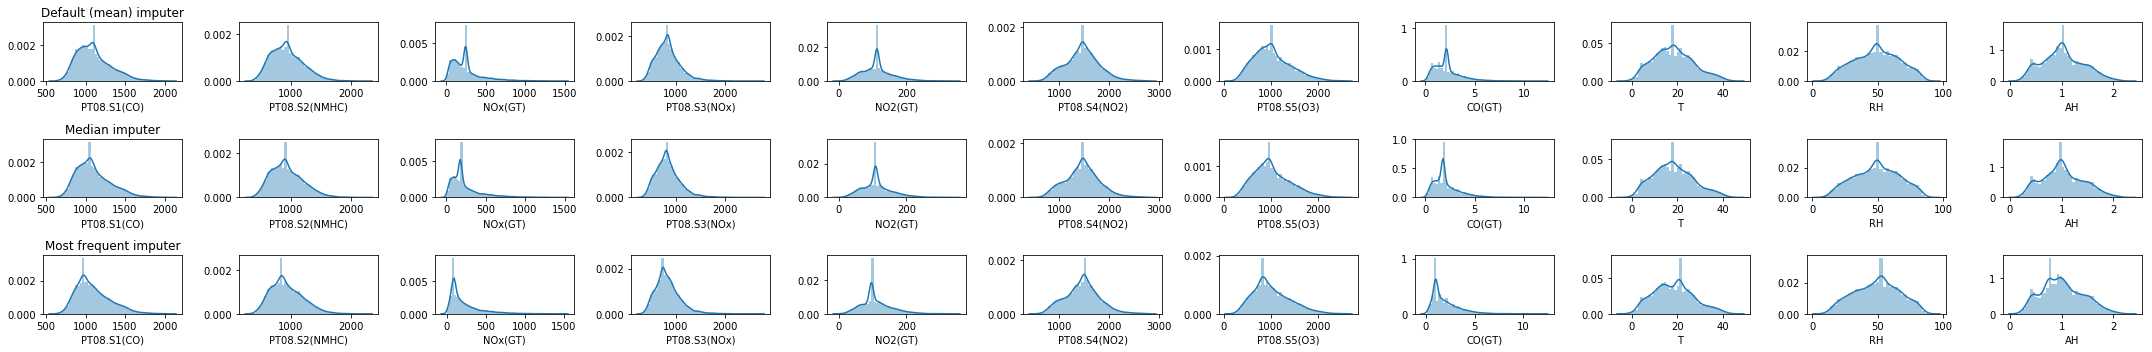

In [34]:
f, axes = plt.subplots(3, len(X_def_imputed.columns), figsize=(30, 5))
for i, column in enumerate(X_def_imputed.columns):
    sns.distplot(X_def_imputed[column], ax=axes[0, i])
    sns.distplot(X_median_imputed[column], ax=axes[1, i])
    sns.distplot(X_most_frequent_imputed[column], ax=axes[2, i])
axes[0, 0].set_title("Default (mean) imputer")
axes[1, 0].set_title("Median imputer")
axes[2, 0].set_title("Most frequent imputer")
plt.tight_layout()
plt.show()

На данном графике уже можно заметить, что при последней стратегии заполнения пропусков, распределения некоторых признаков менее склонны к мультимодальности (NOx(GT), CO(GT)).

Тем не менее:
    - выраженная асимметрия,
    - мультимодальность,
    - аномалии, вызванные (вероятно) заполнением пропусков

говорят о плохом качестве данных.

Попробуем применить квантильное преобразование, чтобы как-то сгладить эти неровности:

In [35]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)

In [36]:
columns = X_def_imputed.columns
index = X_def_imputed.index
X_def_imputed = pd.DataFrame(
    quantile_transformer.fit_transform(X_def_imputed),
    columns=columns,
    index=index
)
X_median_imputed = pd.DataFrame(
    quantile_transformer.fit_transform(X_median_imputed),
    columns=columns,
    index=index
)
X_most_frequent_imputed = pd.DataFrame(
    quantile_transformer.fit_transform(X_most_frequent_imputed),
    columns=columns,
    index=index
)

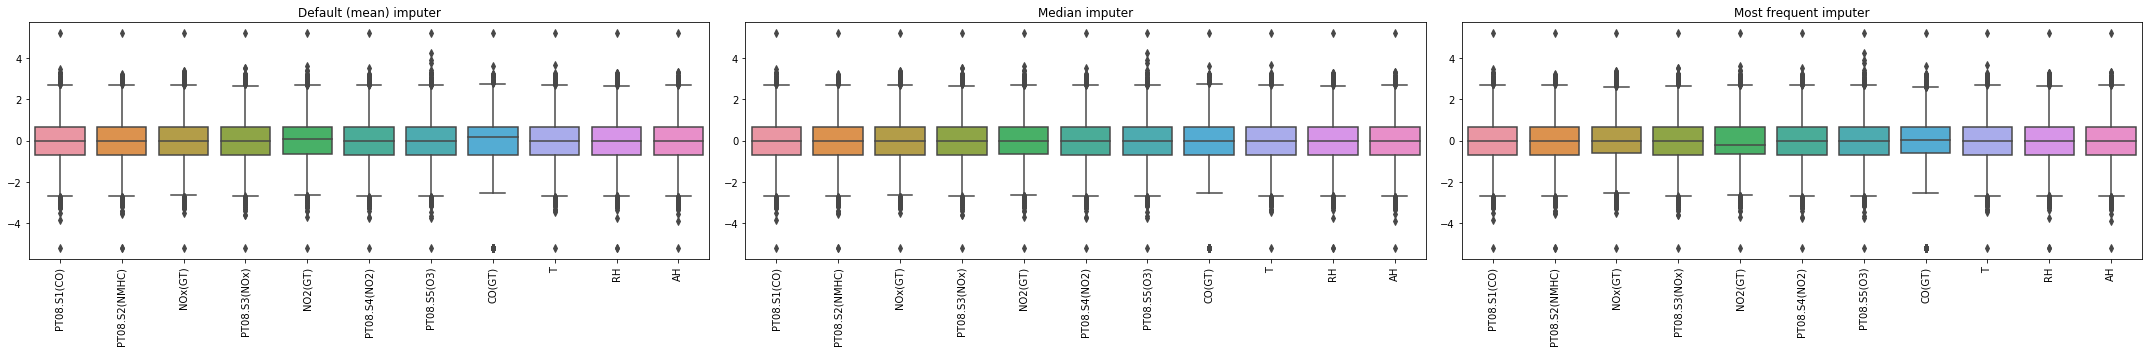

In [37]:
f, axes = plt.subplots(1, 3, figsize=(30, 5))
sns.boxplot(data=X_def_imputed, ax=axes[0])
sns.boxplot(data=X_median_imputed, ax=axes[1])
sns.boxplot(data=X_most_frequent_imputed, ax=axes[2])
axes[0].set_title("Default (mean) imputer")
axes[1].set_title("Median imputer")
axes[2].set_title("Most frequent imputer")
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Медианы выровнялись, интерквантильный размах стал практически одинаков по всем признакам.

О количестве потенциальных выбросов сложно сказать что-то определенное, однако уже сейчас можно говорить, что качество данных улучшилось.

Визуально сложно из данных графиков установить какую бы то ни было разницу.

Взглянем на распределения преобразованных признаков:

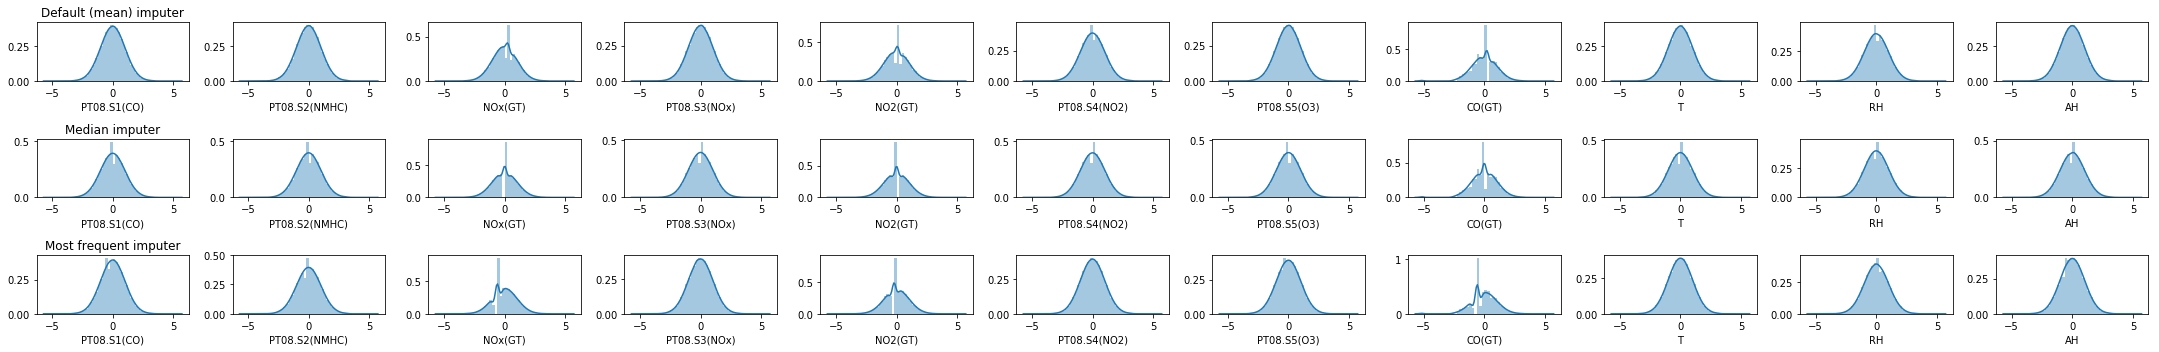

In [38]:
f, axes = plt.subplots(3, len(X_def_imputed.columns), figsize=(30, 5))
for i, column in enumerate(X_def_imputed.columns):
    sns.distplot(X_def_imputed[column], ax=axes[0, i])
    sns.distplot(X_median_imputed[column], ax=axes[1, i])
    sns.distplot(X_most_frequent_imputed[column], ax=axes[2, i])
axes[0, 0].set_title("Default (mean) imputer")
axes[1, 0].set_title("Median imputer")
axes[2, 0].set_title("Most frequent imputer")
plt.tight_layout()
plt.show()

Существенно снизилась асимметрия, однако наличие нескольких пиков в распределениях некоторых признаков все еще присутствует.

В каждой стратегии заполнения можно рассмотреть свои плюсы и минусы.

Судя по данным графикам при дефолтной стратегии можно наблюдать наибольшее количество неразреженных распределений.

Впрочем необходимо построить модели и взглянуть на усредненные значения метрик качества, тогда можно будет делать какие-то выводы.

In [39]:
X_train_def_imputed, X_test_def_imputed, y_train_def_imputed, y_test_def_imputed = train_test_split(
    X_def_imputed,
    Y_def_imputed,
    test_size=0.33,
    random_state=0,
    shuffle=False
)
X_train_median_imputed, X_test_median_imputed, y_train_median_imputed, y_test_median_imputed = train_test_split(
    X_median_imputed,
    Y_median_imputed,
    test_size=0.33,
    random_state=0,
    shuffle=False
)
X_train_most_frequent_imputed, X_test_most_frequent_imputed, y_train_most_frequent_imputed, y_test_most_frequent_imputed = train_test_split(
    X_most_frequent_imputed,
    Y_most_frequent_imputed,
    test_size=0.33,
    random_state=0,
    shuffle=False
)

Здесь мы сначала глянем на самый простой случай, без использования TimeSeriesSplit, без усреднения,
просто чтобы посмотреть, что получится после применения линейного регрессора на дефолтных параметрах (без тюнинга, без добавления каких-либо трансформаций признаков и т.д.):

In [40]:
l_r_def_imputed = LinearRegression()
l_r_median_imputed = LinearRegression()
l_r_most_frequent_imputed = LinearRegression()

In [41]:
l_r_def_imputed.fit(X_train_def_imputed, y_train_def_imputed)
y_pred_def_imputed = l_r_def_imputed.predict(X_test_def_imputed)

l_r_median_imputed.fit(X_train_median_imputed, y_train_median_imputed)
y_pred_median_imputed = l_r_median_imputed.predict(X_test_median_imputed)

l_r_most_frequent_imputed.fit(X_train_most_frequent_imputed, y_train_most_frequent_imputed)
y_pred_most_frequent_imputed = l_r_most_frequent_imputed.predict(X_test_most_frequent_imputed)

In [42]:
explained_variance_score_def_imputed = explained_variance_score(y_test_def_imputed.values, y_pred_def_imputed)
mean_absolute_error_def_imputed = mean_absolute_error(y_test_def_imputed.values, y_pred_def_imputed)
mean_squared_error_def_imputed = mean_squared_error(y_test_def_imputed.values, y_pred_def_imputed)
median_absolute_error_def_imputed = median_absolute_error(y_test_def_imputed.values, y_pred_def_imputed)
r2_score_def_imputed = r2_score(y_test_def_imputed.values, y_pred_def_imputed)


explained_variance_score_median_imputed = explained_variance_score(y_test_median_imputed.values, y_pred_median_imputed)
mean_absolute_error_median_imputed = mean_absolute_error(y_test_median_imputed.values, y_pred_median_imputed)
mean_squared_error_median_imputed = mean_squared_error(y_test_median_imputed.values, y_pred_median_imputed)
median_absolute_error_median_imputed = median_absolute_error(y_test_median_imputed.values, y_pred_median_imputed)
r2_score_median_imputed = r2_score(y_test_median_imputed.values, y_pred_median_imputed)


explained_variance_score_most_frequent_imputed = explained_variance_score(y_test_most_frequent_imputed.values, y_pred_most_frequent_imputed)
mean_absolute_error_most_frequent_imputed = mean_absolute_error(y_test_most_frequent_imputed.values, y_pred_most_frequent_imputed)
mean_squared_error_most_frequent_imputed = mean_squared_error(y_test_most_frequent_imputed.values, y_pred_most_frequent_imputed)
median_absolute_error_most_frequent_imputed = median_absolute_error(y_test_most_frequent_imputed.values, y_pred_most_frequent_imputed)
r2_score_most_frequent_imputed = r2_score(y_test_most_frequent_imputed.values, y_pred_most_frequent_imputed)

In [43]:
print("Default (mean) imputation:\n\ttest explained variance score - {},\n\ttest mean absolute error - {},\n\ttest mean squared error - {},\n\ttest median absolute error - {},\n\ttest r2 score - {}".format(
    round(explained_variance_score_def_imputed, 4),
    round(mean_absolute_error_def_imputed, 4),
    round(mean_squared_error_def_imputed, 4),
    round(median_absolute_error_def_imputed, 4),
    round(r2_score_def_imputed, 4)
))
print("Median imputation:\n\ttest explained variance score - {},\n\ttest mean absolute error - {},\n\ttest mean squared error - {},\n\ttest median absolute error - {},\n\ttest r2 score - {}".format(
    round(explained_variance_score_median_imputed, 4),
    round(mean_absolute_error_median_imputed, 4),
    round(mean_squared_error_median_imputed, 4),
    round(median_absolute_error_median_imputed, 4),
    round(r2_score_median_imputed, 4)
))
print("Most frequent imputation:\n\ttest explained variance score - {},\n\ttest mean absolute error - {},\n\ttest mean squared error - {},\n\ttest median absolute error - {},\n\ttest r2 score - {}".format(
    round(explained_variance_score_most_frequent_imputed, 4),
    round(mean_absolute_error_most_frequent_imputed, 4),
    round(mean_squared_error_most_frequent_imputed, 4),
    round(median_absolute_error_most_frequent_imputed, 4),
    round(r2_score_most_frequent_imputed, 4)
))

Default (mean) imputation:
	test explained variance score - 0.89,
	test mean absolute error - 1.4356,
	test mean squared error - 5.2762,
	test median absolute error - 0.8613,
	test r2 score - 0.879
Median imputation:
	test explained variance score - 0.875,
	test mean absolute error - 1.555,
	test mean squared error - 5.6786,
	test median absolute error - 0.9998,
	test r2 score - 0.8695
Most frequent imputation:
	test explained variance score - 0.8419,
	test mean absolute error - 1.8098,
	test mean squared error - 7.3649,
	test median absolute error - 1.0654,
	test r2 score - 0.837


Пока что, судя по первичному прогону по всем метрикам дефолтная стратегия заполнения пропусков (при дефолтных гиперпараматрах регрессора) превосходит остальные.

В наилучшем случае удалось объяснить примерно 88% вариации целевого признака, что довольно неплохо для baseline-регрессора.

Глянем награфики полученных предсказаний:

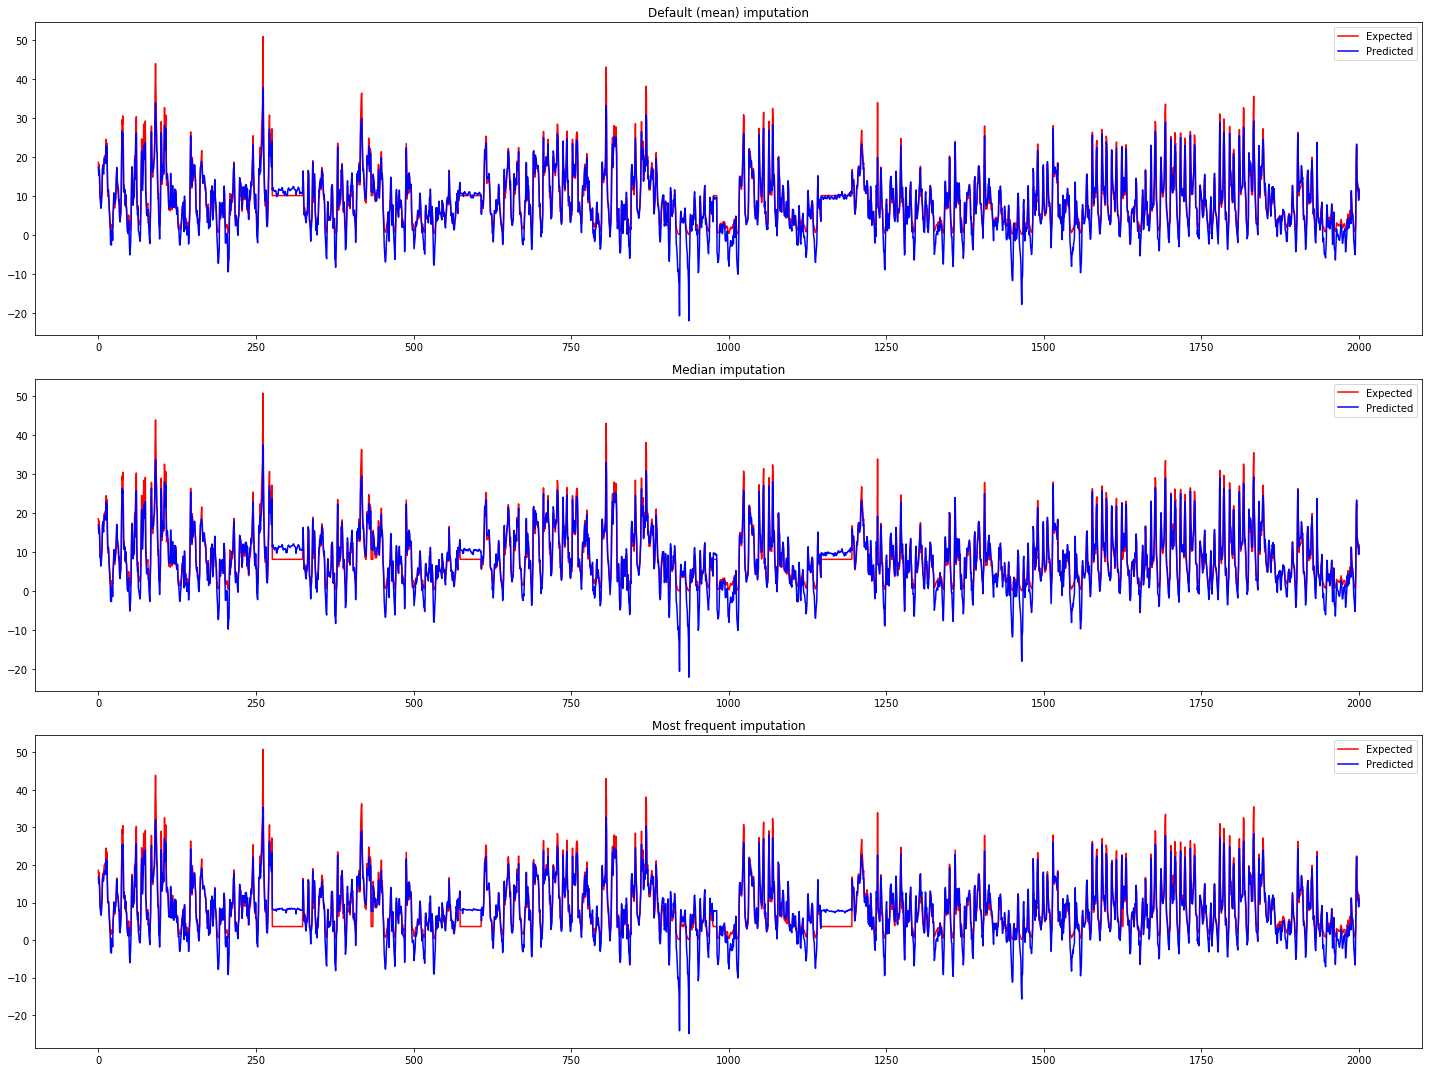

In [44]:
x = np.linspace(0, 2000, y_pred_median_imputed.size)
f, axes = plt.subplots(3, 1, figsize=(20, 15))

axes[0].plot(x, y_test_def_imputed, 'r-', label="Expected")
axes[0].plot(x, y_pred_def_imputed, 'b-', label="Predicted")
axes[0].legend(loc="best")
axes[0].title.set_text("Default (mean) imputation")

axes[1].plot(x, y_test_median_imputed, 'r-', label="Expected")
axes[1].plot(x, y_pred_median_imputed, 'b-', label="Predicted")
axes[1].legend(loc="best")
axes[1].title.set_text("Median imputation")

axes[2].plot(x, y_test_most_frequent_imputed, 'r-', label="Expected")
axes[2].plot(x, y_pred_most_frequent_imputed, 'b-', label="Predicted")
axes[2].legend(loc="best")
axes[2].title.set_text("Most frequent imputation")
plt.tight_layout()
plt.show()

На графике присутствуют три довольно спокойных прямых участка.

Можно заметить, что при первой стратегии сходство между реальными и предсказанными значениями на данных участках оказывается максимальным.

В остальном графики более-менее сопоставимы друг с другом.

Попробуем теперь оценить усредненные оценки метрик на кросс-валидации:

In [45]:
scoring=['explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'r2']
l_r_def_imputed = LinearRegression()
l_r_median_imputed = LinearRegression()
l_r_most_frequent_imputed = LinearRegression()

score_def_imputed = cross_validate(
    l_r_def_imputed,
    X_def_imputed,
    Y_def_imputed,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10)
)
score_median_imputed = cross_validate(
    l_r_median_imputed,
    X_median_imputed,
    Y_median_imputed,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10)
)
score_most_frequent_imputed = cross_validate(
    l_r_most_frequent_imputed,
    X_most_frequent_imputed,
    Y_most_frequent_imputed,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10)
)

In [46]:
print("Default (mean) imputation:\n\ttest explained variance score - {},\n\ttest mean absolute error - {},\n\ttest mean squared error - {},\n\ttest median absolute error - {},\n\ttest r2 score - {}".format(
    round(np.mean(score_def_imputed['test_explained_variance']), 4),
    round(abs(np.mean(score_def_imputed['test_neg_mean_absolute_error'])), 4),
    round(abs(np.mean(score_def_imputed['test_neg_mean_squared_error'])), 4),
    round(abs(np.mean(score_def_imputed['test_neg_median_absolute_error'])), 4),
    round(np.mean(score_def_imputed['test_r2']), 4)
))
print("Median imputation:\n\ttest explained variance score - {},\n\ttest mean absolute error - {},\n\ttest mean squared error - {},\n\ttest median absolute error - {},\n\ttest r2 score - {}".format(
    round(np.mean(score_median_imputed['test_explained_variance']), 4),
    round(abs(np.mean(score_median_imputed['test_neg_mean_absolute_error'])), 4),
    round(abs(np.mean(score_median_imputed['test_neg_mean_squared_error'])), 4),
    round(abs(np.mean(score_median_imputed['test_neg_median_absolute_error'])), 4),
    round(np.mean(score_median_imputed['test_r2']), 4)
))
print("Most frequent imputation:\n\ttest explained variance score - {},\n\ttest mean absolute error - {},\n\ttest mean squared error - {},\n\ttest median absolute error - {},\n\ttest r2 score - {}".format(
    round(np.mean(score_most_frequent_imputed['test_explained_variance']), 4),
    round(abs(np.mean(score_most_frequent_imputed['test_neg_mean_absolute_error'])), 4),
    round(abs(np.mean(score_most_frequent_imputed['test_neg_mean_squared_error'])), 4),
    round(abs(np.mean(score_most_frequent_imputed['test_neg_median_absolute_error'])), 4),
    round(np.mean(score_most_frequent_imputed['test_r2']), 4)
))

Default (mean) imputation:
	test explained variance score - 0.9162,
	test mean absolute error - 1.5661,
	test mean squared error - 5.6594,
	test median absolute error - 1.0757,
	test r2 score - 0.881
Median imputation:
	test explained variance score - 0.9109,
	test mean absolute error - 1.6879,
	test mean squared error - 6.2801,
	test median absolute error - 1.2172,
	test r2 score - 0.8668
Most frequent imputation:
	test explained variance score - 0.8927,
	test mean absolute error - 2.0499,
	test mean squared error - 8.2005,
	test median absolute error - 1.5749,
	test r2 score - 0.8334


С точки зрения метрик, усредненных на кросс-валидации первая стратегия снова превосходит остальные.

Добавим к имеющимся признакам их квадраты:

In [47]:
for column in X_def_imputed.columns:
    X_def_imputed[column + '_2'] = X_def_imputed[column] ** 2
for column in X_median_imputed.columns:
    X_median_imputed[column + '_2'] = X_median_imputed[column] ** 2
for column in X_most_frequent_imputed.columns:
    X_most_frequent_imputed[column + '_2'] = X_most_frequent_imputed[column] ** 2

In [48]:
l_r_def_imputed = LinearRegression()
l_r_median_imputed = LinearRegression()
l_r_most_frequent_imputed = LinearRegression()

In [49]:
score_def_imputed = cross_validate(
    l_r_def_imputed,
    X_def_imputed,
    Y_def_imputed,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10)
)
score_median_imputed = cross_validate(
    l_r_median_imputed,
    X_median_imputed,
    Y_median_imputed,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10)
)
score_most_frequent_imputed = cross_validate(
    l_r_most_frequent_imputed,
    X_most_frequent_imputed,
    Y_most_frequent_imputed,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10)
)
print("Default (mean) imputation:\n\texplained variance score - {},\n\tmean absolute error - {},\n\tmean squared error - {},\n\tmedian absolute error - {},\n\tr2 score - {}".format(
    round(np.mean(score_def_imputed['test_explained_variance']), 4),
    round(abs(np.mean(score_def_imputed['test_neg_mean_absolute_error'])), 4),
    round(abs(np.mean(score_def_imputed['test_neg_mean_squared_error'])), 4),
    round(abs(np.mean(score_def_imputed['test_neg_median_absolute_error'])), 4),
    round(np.mean(score_def_imputed['test_r2']), 4)
))
print("Median imputation:\n\ttest explained variance score - {},\n\ttest mean absolute error - {},\n\ttest mean squared error - {},\n\ttest median absolute error - {},\n\ttest r2 score - {}".format(
    round(np.mean(score_median_imputed['test_explained_variance']), 4),
    round(abs(np.mean(score_median_imputed['test_neg_mean_absolute_error'])), 4),
    round(abs(np.mean(score_median_imputed['test_neg_mean_squared_error'])), 4),
    round(abs(np.mean(score_median_imputed['test_neg_median_absolute_error'])), 4),
    round(np.mean(score_median_imputed['test_r2']), 4)
))
print("Most frequent imputation:\n\ttest explained variance score - {},\n\ttest mean absolute error - {},\n\ttest mean squared error - {},\n\ttest median absolute error - {},\n\ttest r2 score - {}".format(
    round(np.mean(score_most_frequent_imputed['test_explained_variance']), 4),
    round(abs(np.mean(score_most_frequent_imputed['test_neg_mean_absolute_error'])), 4),
    round(abs(np.mean(score_most_frequent_imputed['test_neg_mean_squared_error'])), 4),
    round(abs(np.mean(score_most_frequent_imputed['test_neg_median_absolute_error'])), 4),
    round(np.mean(score_most_frequent_imputed['test_r2']), 4)
))

Default (mean) imputation:
	explained variance score - 0.9944,
	mean absolute error - 0.2716,
	mean squared error - 0.2759,
	median absolute error - 0.1912,
	r2 score - 0.9942
Median imputation:
	test explained variance score - 0.9948,
	test mean absolute error - 0.2321,
	test mean squared error - 0.2462,
	test median absolute error - 0.1738,
	test r2 score - 0.9947
Most frequent imputation:
	test explained variance score - 0.9902,
	test mean absolute error - 0.3753,
	test mean squared error - 0.4676,
	test median absolute error - 0.2937,
	test r2 score - 0.9897


Судя по результатам качество предсказания существенно улучшилось благодаря введению данных искусственных признаков

Отобразим теперь графически результаты предсказаний:

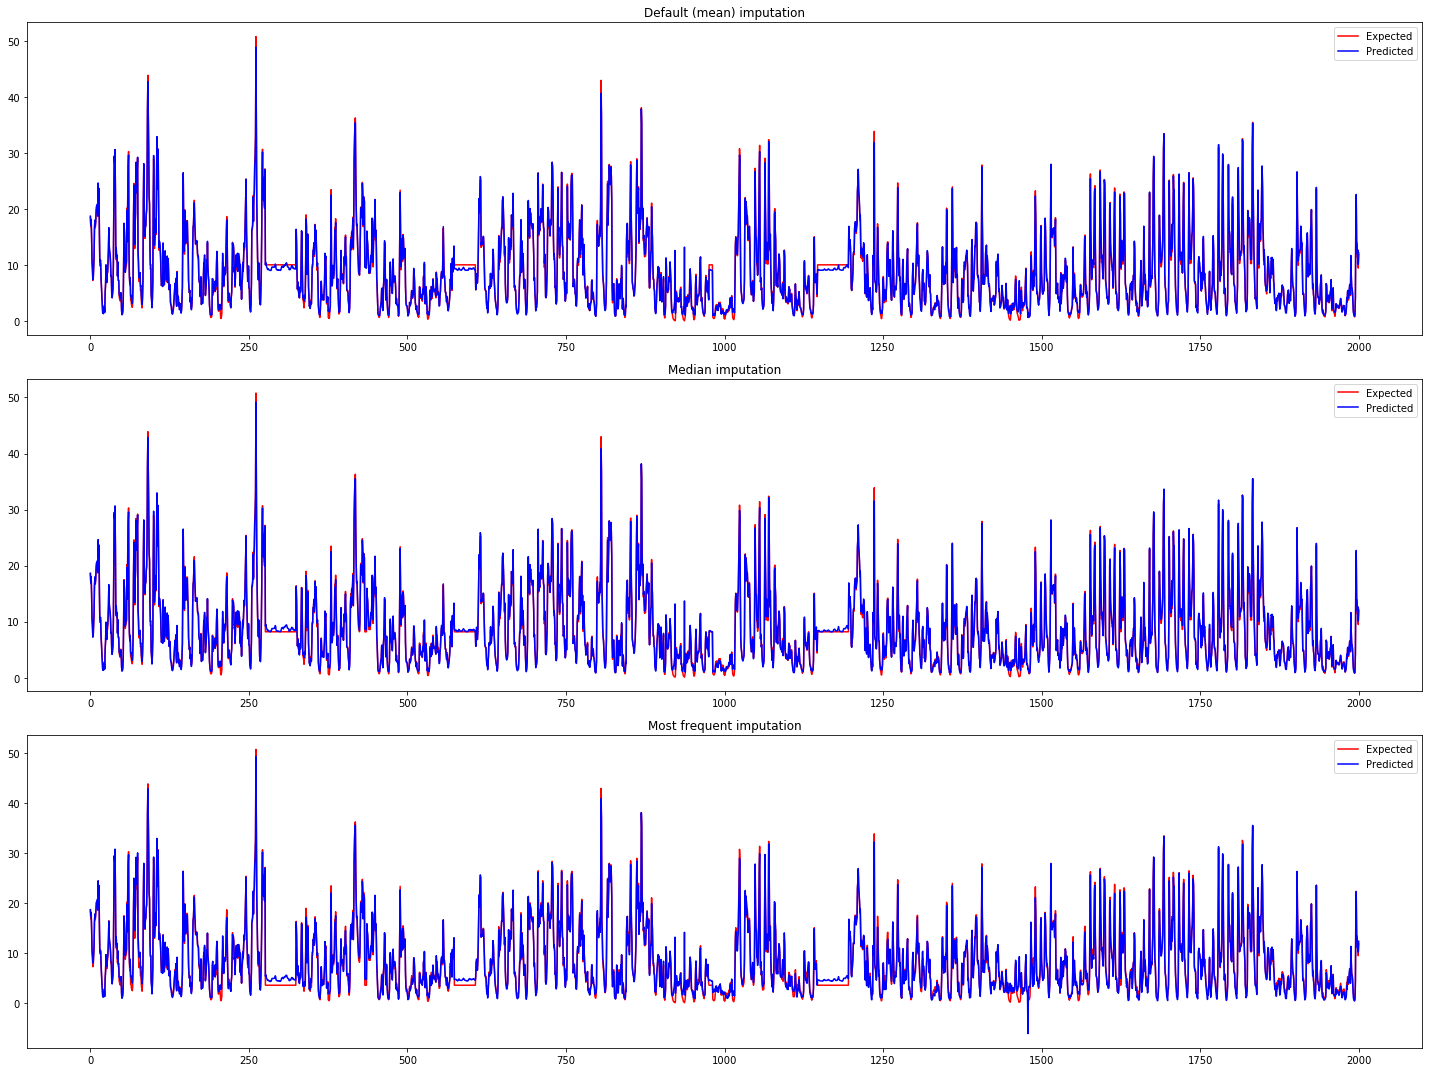

In [50]:
X_train_def_imputed, X_test_def_imputed, y_train_def_imputed, y_test_def_imputed = train_test_split(
    X_def_imputed,
    Y_def_imputed,
    test_size=0.33,
    random_state=0,
    shuffle=False
)
X_train_median_imputed, X_test_median_imputed, y_train_median_imputed, y_test_median_imputed = train_test_split(
    X_median_imputed,
    Y_median_imputed,
    test_size=0.33,
    random_state=0,
    shuffle=False
)
X_train_most_frequent_imputed, X_test_most_frequent_imputed, y_train_most_frequent_imputed, y_test_most_frequent_imputed = train_test_split(
    X_most_frequent_imputed,
    Y_most_frequent_imputed,
    test_size=0.33,
    random_state=0,
    shuffle=False
)

l_r_def_imputed = LinearRegression()
l_r_median_imputed = LinearRegression()
l_r_most_frequent_imputed = LinearRegression()

l_r_def_imputed.fit(X_train_def_imputed, y_train_def_imputed)
y_pred_def_imputed = l_r_def_imputed.predict(X_test_def_imputed)

l_r_median_imputed.fit(X_train_median_imputed, y_train_median_imputed)
y_pred_median_imputed = l_r_median_imputed.predict(X_test_median_imputed)

l_r_most_frequent_imputed.fit(X_train_most_frequent_imputed, y_train_most_frequent_imputed)
y_pred_most_frequent_imputed = l_r_most_frequent_imputed.predict(X_test_most_frequent_imputed)

x = np.linspace(0, 2000, y_pred_median_imputed.size)
f, axes = plt.subplots(3, 1, figsize=(20, 15))

axes[0].plot(x, y_test_def_imputed, 'r-', label="Expected")
axes[0].plot(x, y_pred_def_imputed, 'b-', label="Predicted")
axes[0].legend(loc="best")
axes[0].title.set_text("Default (mean) imputation")

axes[1].plot(x, y_test_median_imputed, 'r-', label="Expected")
axes[1].plot(x, y_pred_median_imputed, 'b-', label="Predicted")
axes[1].legend(loc="best")
axes[1].title.set_text("Median imputation")

axes[2].plot(x, y_test_most_frequent_imputed, 'r-', label="Expected")
axes[2].plot(x, y_pred_most_frequent_imputed, 'b-', label="Predicted")
axes[2].legend(loc="best")
axes[2].title.set_text("Most frequent imputation")
plt.tight_layout()
plt.show()

Попробуем теперь оптимизировать гиперпараметры на Lasso и Ridge классификаторах:

In [52]:
lasso_g_s_params = {'alpha': np.arange(0.1, 10, 0.1), 'fit_intercept': [True, False], 'selection': ['cyclic', 'random']}
ridge_g_s_params = {'alpha': np.arange(0.1, 10, 0.1), 'fit_intercept': [True, False], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [53]:
lasso_g_s_def_imputed = GridSearchCV(
    Lasso(random_state=0),
    param_grid=lasso_g_s_params,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10),
    refit='r2',
    n_jobs=8
)
lasso_g_s_median_imputed = GridSearchCV(
    Lasso(random_state=0),
    param_grid=lasso_g_s_params,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10),
    refit='r2',
    n_jobs=8
)
lasso_g_s_most_frequent_imputed = GridSearchCV(
    Lasso(random_state=0),
    param_grid=lasso_g_s_params,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10),
    refit='r2',
    n_jobs=8
)

In [54]:
lasso_g_s_def_imputed.fit(X_def_imputed, Y_def_imputed)
lasso_g_s_median_imputed.fit(X_median_imputed, Y_median_imputed)
lasso_g_s_most_frequent_imputed.fit(X_most_frequent_imputed, Y_most_frequent_imputed)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': array([ 0.1,  0.2, ...,  9.8,  9.9]), 'fit_intercept': [True, False], 'selection': ['cyclic', 'random']},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring=['explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'r2'],
       verbose=0)

In [55]:
ridge_g_s_def_imputed = GridSearchCV(
    Ridge(random_state=0),
    param_grid=ridge_g_s_params,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10),
    refit='r2',
    n_jobs=8
)
ridge_g_s_median_imputed = GridSearchCV(
    Ridge(random_state=0),
    param_grid=ridge_g_s_params,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10),
    refit='r2',
    n_jobs=8
)
ridge_g_s_most_frequent_imputed = GridSearchCV(
    Ridge(random_state=0),
    param_grid=ridge_g_s_params,
    scoring=scoring,
    cv=TimeSeriesSplit(n_splits=10),
    refit='r2',
    n_jobs=8
)

In [56]:
ridge_g_s_def_imputed.fit(X_def_imputed, Y_def_imputed)
ridge_g_s_median_imputed.fit(X_median_imputed, Y_median_imputed)
ridge_g_s_most_frequent_imputed.fit(X_most_frequent_imputed, Y_most_frequent_imputed)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=0, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': array([ 0.1,  0.2, ...,  9.8,  9.9]), 'fit_intercept': [True, False], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring=['explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'r2'],
       verbose=0)

Глянем на лучшие усреднения r2 score:

In [57]:
print(lasso_g_s_def_imputed.best_score_)
print(lasso_g_s_median_imputed.best_score_)
print(lasso_g_s_most_frequent_imputed.best_score_)

0.992952461635
0.993402341099
0.98225331113


In [58]:
print(ridge_g_s_def_imputed.best_score_)
print(ridge_g_s_median_imputed.best_score_)
print(ridge_g_s_most_frequent_imputed.best_score_)

0.994240562476
0.994725308209
0.989763507739


Любопытно, что применение L1 и L2 регуляризаторов не дало повышения доли объясненной дисперсии.

Впрочем, возможно применение регуляризации позволило сократить время сходимости или уменьшило количество необходимых предикторов:

In [59]:
data = {
    'l_r_def_imputed': l_r_def_imputed.coef_,
    'l_r_median_imputed': l_r_median_imputed.coef_,
    'l_r_most_frequent_imputed': l_r_most_frequent_imputed.coef_,
    'lasso_g_s_def_imputed': lasso_g_s_def_imputed.best_estimator_.coef_,
    'lasso_g_s_median_imputed': lasso_g_s_median_imputed.best_estimator_.coef_,
    'lasso_g_s_most_frequent_imputed': lasso_g_s_most_frequent_imputed.best_estimator_.coef_,
    'ridge_g_s_def_imputed': ridge_g_s_def_imputed.best_estimator_.coef_,
    'ridge_g_s_median_imputed': ridge_g_s_median_imputed.best_estimator_.coef_,
    'ridge_g_s_most_frequent_imputed': ridge_g_s_most_frequent_imputed.best_estimator_.coef_
}
coeff = pd.DataFrame(data=data)

In [60]:
coeff

,l_r_def_imputed,l_r_median_imputed,l_r_most_frequent_imputed,lasso_g_s_def_imputed,lasso_g_s_median_imputed,lasso_g_s_most_frequent_imputed,ridge_g_s_def_imputed,ridge_g_s_median_imputed,ridge_g_s_most_frequent_imputed
0,0.075173,0.029109,0.069202,0.000000,0.000000,0.089228,-0.021352,-0.069901,0.140815
1,6.641900,6.526943,7.014227,6.750207,6.740787,6.613666,6.710025,6.654961,7.048871
2,0.035009,0.082981,-0.000235,0.000000,0.000000,-0.000000,0.063461,0.035211,-0.100444
3,0.020332,-0.050376,0.375146,-0.000000,-0.000000,-0.000000,0.035662,-0.059582,0.247358
4,0.025636,0.042143,0.087887,0.000000,0.000000,-0.000000,0.045973,0.038051,0.074055
5,-0.070466,0.106996,-0.235295,0.044345,0.054707,0.000000,0.097815,0.195359,-0.304401
6,0.080762,0.063595,0.147644,0.006979,0.012452,0.119447,0.054608,0.075992,0.169924
7,0.050323,-0.003551,0.019601,0.013903,0.000000,-0.000000,0.002874,-0.046190,-0.042384
8,0.128574,0.246283,-1.848131,0.000000,0.000000,0.000000,0.077877,0.080465,-1.904402
9,0.044792,0.130730,-1.284215,0.000000,0.000000,-0.000000,0.062065,0.081318,-1.385294


Из данной сводной таблицы не вполне понятно, в каком случае и каким количеством предикторов достигается полученное качество.

Введем некий порог для абсолютного значения коэффициента и посмотрим, какое количество преодолевают этот порог.

Добавим также в таблицу общее количество признаков, преодолевших установленный порог значимости и лучшее качество (r2 score), полученное на соответствующем регрессоре:

In [61]:
def threshold(coef):
    return int(abs(coef) > 0.05)

In [62]:
coeff_adj = coeff.applymap(threshold)
coeff_adj.index = X_def_imputed.columns
features_counts = coeff_adj.apply(sum, axis=0)
features_counts.name = 'Features_count'
scores = pd.Series(data={
    'l_r_def_imputed': np.mean(score_def_imputed['test_r2']),
    'l_r_median_imputed': np.mean(score_median_imputed['test_r2']),
    'l_r_most_frequent_imputed': np.mean(score_most_frequent_imputed['test_r2']),
    'lasso_g_s_def_imputed': lasso_g_s_def_imputed.best_score_,
    'lasso_g_s_median_imputed': lasso_g_s_median_imputed.best_score_,
    'lasso_g_s_most_frequent_imputed': lasso_g_s_most_frequent_imputed.best_score_,
    'ridge_g_s_def_imputed': ridge_g_s_def_imputed.best_score_,
    'ridge_g_s_median_imputed': ridge_g_s_median_imputed.best_score_,
    'ridge_g_s_most_frequent_imputed': ridge_g_s_most_frequent_imputed.best_score_
}, name='r2_score')
coeff_adj = coeff_adj.append(features_counts)
coeff_adj = coeff_adj.append(scores)

In [63]:
coeff_adj

,l_r_def_imputed,l_r_median_imputed,l_r_most_frequent_imputed,lasso_g_s_def_imputed,lasso_g_s_median_imputed,lasso_g_s_most_frequent_imputed,ridge_g_s_def_imputed,ridge_g_s_median_imputed,ridge_g_s_most_frequent_imputed
PT08.S1(CO),1.000000,0.00000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
PT08.S2(NMHC),1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NOx(GT),0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
PT08.S3(NOx),0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
NO2(GT),0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
PT08.S4(NO2),1.000000,1.00000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
PT08.S5(O3),1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
CO(GT),1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
RH,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000


Из приведенной таблицы видно, что наилучшего качества (с точки зрения объясненной дисперсии) удалось достичь на обычном классификаторе при медианной стратегии заполнения пропусков, 
однако для этого потребовалось задействовать  12 предикторов.

С другой стороны применение L1-регуляризации с подбором параметров по сетке при заполнении пропусков средними позволило достичь схожего качества, используя в три (!) раза меньше предикторов.

Напоследок взглянем на распределение остатков во всех ситуациях:

In [64]:
residuals = pd.DataFrame(data = {
    'l_r_def_imputed': [y_test - y_pred for y_test, y_pred in zip(y_test_def_imputed, y_pred_def_imputed)],
    'l_r_median_imputed': [y_test - y_pred for y_test, y_pred in zip(y_test_median_imputed, y_pred_median_imputed)],
    'l_r_most_frequent_imputed': [y_test - y_pred for y_test, y_pred in zip(y_test_most_frequent_imputed, y_pred_most_frequent_imputed)],
    'lasso_g_s_def_imputed': [y_test - y_pred for y_test, y_pred in zip(y_test_def_imputed, lasso_g_s_def_imputed.best_estimator_.predict(X_test_def_imputed))],
    'lasso_g_s_median_imputed': [y_test - y_pred for y_test, y_pred in zip(y_test_median_imputed, lasso_g_s_median_imputed.best_estimator_.predict(X_test_median_imputed))],
    'lasso_g_s_most_frequent_imputed': [y_test - y_pred for y_test, y_pred in zip(y_test_most_frequent_imputed, lasso_g_s_most_frequent_imputed.best_estimator_.predict(X_test_most_frequent_imputed))],
    'ridge_g_s_def_imputed': [y_test - y_pred for y_test, y_pred in zip(y_test_def_imputed, ridge_g_s_def_imputed.best_estimator_.predict(X_test_def_imputed))],
    'ridge_g_s_median_imputed': [y_test - y_pred for y_test, y_pred in zip(y_test_median_imputed, ridge_g_s_median_imputed.best_estimator_.predict(X_test_median_imputed))],
    'ridge_g_s_most_frequent_imputed': [y_test - y_pred for y_test, y_pred in zip(y_test_most_frequent_imputed, ridge_g_s_most_frequent_imputed.best_estimator_.predict(X_test_most_frequent_imputed))]
})

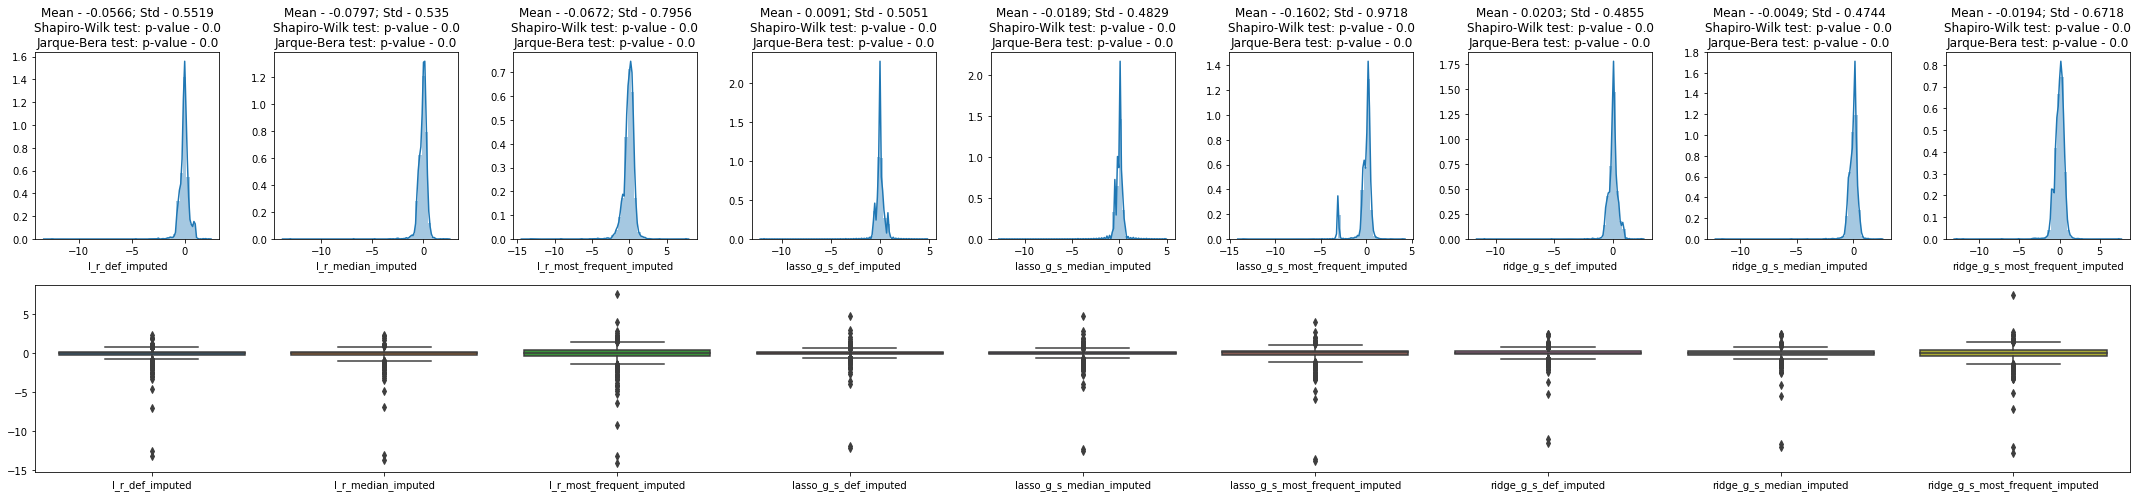

In [95]:
message = "Mean - {}; Std - {}\nShapiro-Wilk test: p-value - {}\nJarque-Bera test: p-value - {}"
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot(312)
ax2 = plt.subplot(391)
ax3 = plt.subplot(392)
ax4 = plt.subplot(393)
ax5 = plt.subplot(394)
ax6 = plt.subplot(395)
ax7 = plt.subplot(396)
ax8 = plt.subplot(397)
ax9 = plt.subplot(398)
ax10 = plt.subplot(399)
ax2.set_title(message.format(round(np.mean(residuals[residuals.columns[0]]), 4), round(np.std(residuals[residuals.columns[0]]), 4), shapiro(residuals[residuals.columns[0]])[1], jarque_bera(residuals[residuals.columns[0]])[1]))
ax3.set_title(message.format(round(np.mean(residuals[residuals.columns[1]]), 4), round(np.std(residuals[residuals.columns[1]]), 4), shapiro(residuals[residuals.columns[0]])[1], jarque_bera(residuals[residuals.columns[0]])[1]))
ax4.set_title(message.format(round(np.mean(residuals[residuals.columns[2]]), 4), round(np.std(residuals[residuals.columns[2]]), 4), shapiro(residuals[residuals.columns[0]])[1], jarque_bera(residuals[residuals.columns[0]])[1]))
ax5.set_title(message.format(round(np.mean(residuals[residuals.columns[3]]), 4), round(np.std(residuals[residuals.columns[3]]), 4), shapiro(residuals[residuals.columns[0]])[1], jarque_bera(residuals[residuals.columns[0]])[1]))
ax6.set_title(message.format(round(np.mean(residuals[residuals.columns[4]]), 4), round(np.std(residuals[residuals.columns[4]]), 4), shapiro(residuals[residuals.columns[0]])[1], jarque_bera(residuals[residuals.columns[0]])[1]))
ax7.set_title(message.format(round(np.mean(residuals[residuals.columns[5]]), 4), round(np.std(residuals[residuals.columns[5]]), 4), shapiro(residuals[residuals.columns[0]])[1], jarque_bera(residuals[residuals.columns[0]])[1]))
ax8.set_title(message.format(round(np.mean(residuals[residuals.columns[6]]), 4), round(np.std(residuals[residuals.columns[6]]), 4), shapiro(residuals[residuals.columns[0]])[1], jarque_bera(residuals[residuals.columns[0]])[1]))
ax9.set_title(message.format(round(np.mean(residuals[residuals.columns[7]]), 4), round(np.std(residuals[residuals.columns[7]]), 4), shapiro(residuals[residuals.columns[0]])[1], jarque_bera(residuals[residuals.columns[0]])[1]))
ax10.set_title(message.format(round(np.mean(residuals[residuals.columns[8]]), 4), round(np.std(residuals[residuals.columns[8]]), 4), shapiro(residuals[residuals.columns[0]])[1], jarque_bera(residuals[residuals.columns[0]])[1]))
sns.distplot(residuals[residuals.columns[0]], ax=ax2)
sns.distplot(residuals[residuals.columns[1]], ax=ax3)
sns.distplot(residuals[residuals.columns[2]], ax=ax4)
sns.distplot(residuals[residuals.columns[3]], ax=ax5)
sns.distplot(residuals[residuals.columns[4]], ax=ax6)
sns.distplot(residuals[residuals.columns[5]], ax=ax7)
sns.distplot(residuals[residuals.columns[6]], ax=ax8)
sns.distplot(residuals[residuals.columns[7]], ax=ax9)
sns.distplot(residuals[residuals.columns[8]], ax=ax10)
sns.boxplot(data=residuals, ax=ax1)
plt.tight_layout()
plt.show()

На графике видно, что в целом для всех случаев ошибки в среднем довольно близки к нулю.

Так же примечательно то, что ни для одного случая распределение остатков не является нормальным.

Это входит в разрез с одним из ограничений на использование линейной регрессии, в соответствие с которым распределение остатков должно быть нормальным, что может говорить о том, что связь между предикторами и целевой переменной, вообще говоря, не является линейной.